In [4]:
import os
import glob
import time
import pickle
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import imageio

from collections import deque
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from imgaug import augmenters as iaa

In [5]:
TEST_SIZE = 0.1
SAMPLE_DISPLAY = 5
SVC_ITER = 10000
SVC_C = 0.001
CV_ITERS = 4
READ_PICKLE = True

FTR_HOG = True
FTR_BIN_SPTL = True
FTR_CLR_HIST = True

COLORSPACE = 'YCrCb'
ORIENT = 9
PIXEL_PER_CELL = 8
CELL_PER_BLOCK = 2
HOG_CHNL = 'ALL'
SPATIAL_SIZE = (32,32)
HISTO_BINS = 32
BINS_RANGE = (0, 256)

SEQ_RTT = iaa.Affine(rotate=(-20, 20)) # rotate by -20 to +20 degrees
SEQ_FLIP = iaa.Fliplr(1.0) # always horizontally flip each input image
SEQ_BLR = iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
SEQ_SHRP = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)) # sharpen images
SEQ_BRT = iaa.Add((-10, 10), per_channel=0.5) # change brightness of images (by -10 to 10 of original value)

In [6]:
VEHICLE_IMG_PATHS = 'C:\\Users\\Yiqun\Downloads\\training_images\\vehicles\\*\\*.png'
NON_VEHICLE_IMG_PATHS = 'C:\\Users\\Yiqun\Downloads\\training_images\\non-vehicles\\*\\*.png'

In [7]:
def extract_hog_features(img, orient, pix_per_cell, cell_per_block, vis = False, feature_vec = True):
    #if call with two outputs then vis = True
    if vis == True:
        features, hog_image = hog(
            img,
            orientations = orient,
            pixels_per_cell = (pix_per_cell, pix_per_cell),
            cells_per_block = (cell_per_block, cell_per_block),
            block_norm = 'L2-Hys',
            transform_sqrt = True,
            visualize = vis,
            feature_vector = feature_vec
        )
        return features, hog_image
    else:
        features = hog(
            img,
            orientations = orient,
            pixels_per_cell = (pix_per_cell, pix_per_cell),
            cells_per_block = (cell_per_block, cell_per_block),
            block_norm = 'L2-Hys',
            transform_sqrt = True,
            visualize = vis,
            feature_vector = feature_vec            
        )
        return features

def extract_bin_spatial(
    image,
    spatial_size = (32, 32)
):
    features = cv2.resize(image, spatial_size).ravel()
    return features

def extract_color_hist(
    image,
    hist_bins=32,
    bins_range=(0,256)
):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:,:,0], bins = hist_bins, range = bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins = hist_bins, range = bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins = hist_bins, range = bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def convert_img_cspace(image, cspace = 'RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    return feature_image

def extract_features(
    img,
    hog = True,
    bin_spatial = True,
    color_histo = True,
    orient = 9,
    pix_per_cell = 8,
    cell_per_block = 2,
    hog_channel = 0,
    hist_bins = 32,
    bins_range = (0, 256),
    spatial_size = (32, 32)
):
    # define an empty list to receive features
    img_features = []

    # compute spatial features if the flag is set:
    if bin_spatial == True:
        spatial_features = extract_bin_spatial(img, spatial_size= spatial_size)
        img_features.append(spatial_features)
    
    # compute color histogram features if flag is set:
    if color_histo == True:
        hist_features = extract_color_hist(
            img, hist_bins = hist_bins, bins_range = bins_range
        )
        img_features.append(hist_features)

    # compute HOG features if flag is set:
    if hog == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(img.shape[2]):
                hog_features.extend(
                    extract_hog_features(
                        img[:,:,channel], orient, pix_per_cell, cell_per_block)
                )
        else:
            hog_features = extract_hog_features(
                        img[:,:,hog_channel], orient, pix_per_cell, cell_per_block)

        #append the new feature vector to the features list:
        img_features.append(hog_features)
    
    return np.concatenate(img_features)

def extract_all_features(
    img_paths,
    cspace = 'RGB',
    hog = True,
    bin_spatial = True,
    color_histo = True,
    orient = 9,
    pix_per_cell = 8,
    cell_per_block = 2,
    hog_channel = 0,
    hist_bins = 32,
    bins_range = (0,256),
    spatial_size = (32, 32)
):
    # Create a list to append feature vectors
    features = []
    # Iterate through the list of the images:
    for file in img_paths:
        # Read in each one:
        image = mpimg.imread(file)

        all_images = [
            image,
#              SEQ_RTT.augment_image(image), 
#             SEQ_FLIP.augment_image(image), 
#              SEQ_BLR.augment_image(image), 
#             SEQ_SHRP.augment_image(image),
#             SEQ_BRT.augment_image(image)            
        ]

        for img in all_images:
            converted = convert_img_cspace(img, cspace)
            feature = extract_features(
                converted,
                hog=hog,
                bin_spatial=bin_spatial,
                color_histo=color_histo,
                orient=orient,
                pix_per_cell=pix_per_cell,
                cell_per_block=cell_per_block, 
                hog_channel=hog_channel,
                hist_bins=hist_bins,
                bins_range=bins_range,
                spatial_size=spatial_size,
            )
            features.append(feature)
    return features

def convert_to_std(img_paths, size):
    """Loops through all image paths, cropping them to be square and resizing."""
    for loc in img_paths:
        image = mpimg.imread(loc)
        
        y = image.shape[0]
        x = image.shape[1]
        if y < x:
            crop_img = image[:y,0:y]
        elif y > x:
            crop_img = image[0:x,:x]
        else:
            crop_img = image

        resized = cv2.resize(crop_img, size)
        mpimg.imsave(loc, resized)

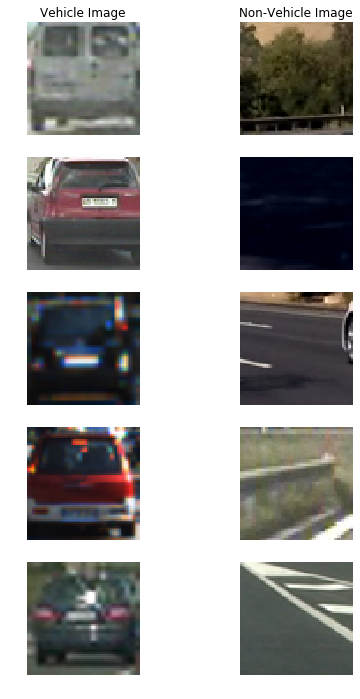

In [8]:
vehicle_img_locs = glob.glob(VEHICLE_IMG_PATHS)
non_vehicle_img_locs = glob.glob(NON_VEHICLE_IMG_PATHS)

convert_to_std(vehicle_img_locs, (64, 64))
convert_to_std(non_vehicle_img_locs, (64, 64))

# Set up figure for plotting
f, axarr = plt.subplots(SAMPLE_DISPLAY, 2)
f.set_size_inches(7,12)

for i in range(SAMPLE_DISPLAY):
    if i == 0:
        axarr[i, 0].set_title("Vehicle Image")
        axarr[i, 1].set_title("Non-Vehicle Image")
    # plot now
    rand_vehicle_img = vehicle_img_locs[random.randrange(len(vehicle_img_locs))]
    rand_non_vehicle_img = non_vehicle_img_locs[random.randrange(len(non_vehicle_img_locs))]
    axarr[i, 0].imshow(mpimg.imread(rand_vehicle_img))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(rand_non_vehicle_img))
    axarr[i, 1].axis('off')

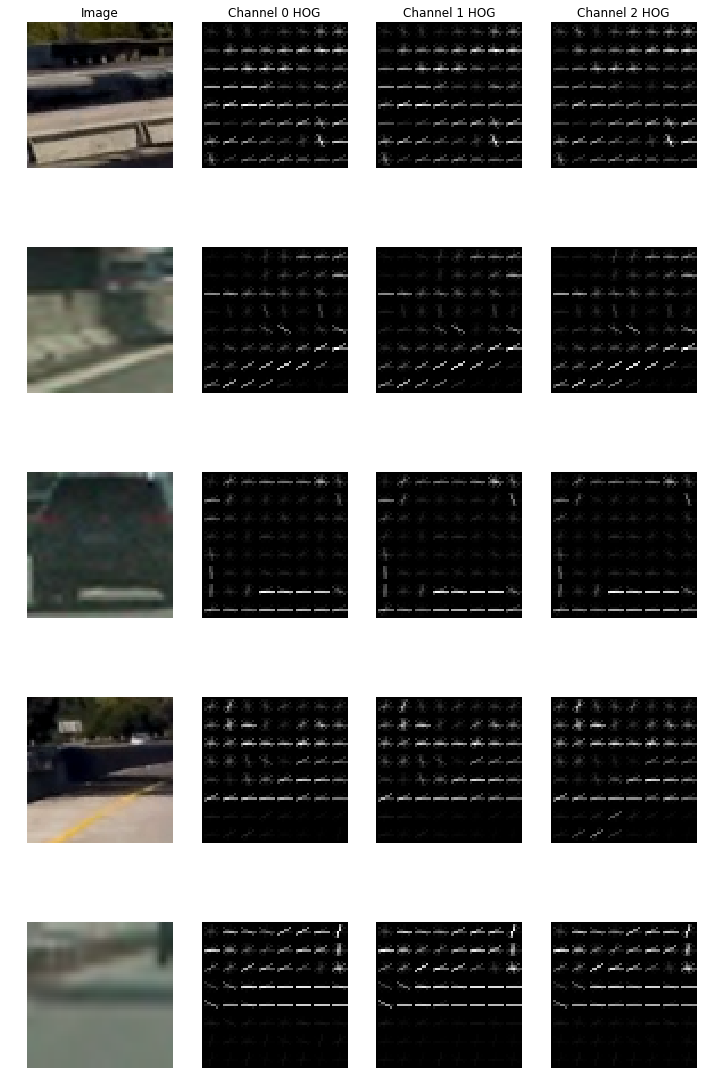

In [9]:
#set up hog figure for plotting
f, axarr = plt.subplots(SAMPLE_DISPLAY, 4)
f.set_size_inches(12, 20)

for i in range(SAMPLE_DISPLAY):
    if i == 0:
        axarr[i,0].set_title("Image")
        axarr[i,1].set_title("Channel 0 HOG")
        axarr[i,2].set_title("Channel 1 HOG")
        axarr[i,3].set_title("Channel 2 HOG")

    if random.random() > 0.5:
        img_loc = vehicle_img_locs[random.randrange(len(vehicle_img_locs))]
    else:
        img_loc = non_vehicle_img_locs[random.randrange(len(non_vehicle_img_locs))]
    img = mpimg.imread(img_loc)

    # Retriece HOG features for image:
    _, c0_hog = extract_hog_features(img[:,:,0], ORIENT, PIXEL_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
    _, c1_hog = extract_hog_features(img[:,:,1], ORIENT, PIXEL_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
    _, c2_hog = extract_hog_features(img[:,:,2], ORIENT, PIXEL_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)

    # Plot images on figure:
    axarr[i, 0].imshow(img)
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(c0_hog, cmap='gray')
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(c1_hog, cmap='gray')
    axarr[i, 2].axis('off')
    axarr[i, 3].imshow(c2_hog, cmap='gray')
    axarr[i, 3].axis('off')


In [7]:
if not READ_PICKLE:
    t = time.time()
    #Extract all vehicle features from vechile images;
    vehicle_features = extract_all_features(
        vehicle_img_locs, 
        cspace=COLORSPACE,
        hog=FTR_HOG,
        bin_spatial=FTR_BIN_SPTL,
        color_histo=FTR_CLR_HIST,
        orient=ORIENT, 
        pix_per_cell=PIXEL_PER_CELL, 
        cell_per_block=CELL_PER_BLOCK, 
        hog_channel=HOG_CHNL,
        hist_bins=HISTO_BINS,
        spatial_size=SPATIAL_SIZE
    )

    # Extract all non-vehicle features from non-vehicle images
    non_vehicle_features = extract_all_features(
        non_vehicle_img_locs, 
        cspace=COLORSPACE,
        hog=FTR_HOG,
        bin_spatial=FTR_BIN_SPTL,
        color_histo=FTR_CLR_HIST,
        orient=ORIENT, 
        pix_per_cell=PIXEL_PER_CELL, 
        cell_per_block=CELL_PER_BLOCK, 
        hog_channel=HOG_CHNL,
        hist_bins=HISTO_BINS,
        spatial_size=SPATIAL_SIZE
    )
    print("Time taken to extract features:  ", time.time() - t, "seconds")
    print("vehicle features:  ", len(vehicle_features))
    print("non vehicle features:  ", len(non_vehicle_features))

Time taken to extract features:   91.87881851196289 seconds
vehicle features:   8792
non vehicle features:   8968


In [8]:
print("Length of feature_vector of each vehicle_feature:  ", len(vehicle_features[0]))
print("Length of feature_vector of each non_vehicle_feature:  ", len(non_vehicle_features[0]))

Length of feature_vector of each vehicle_feature:   8460
Length of feature_vector of each non_vehicle_feature:   8460


In [9]:
if not READ_PICKLE:

    # Create an array stack of feature vectors
    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

    print('Feature Vector and Labels shape: ', X.shape, y.shape)

    # Split up data into random training and testing sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=rand_state
    )

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print(
        'Using:', ORIENT, 'orientations', PIXEL_PER_CELL,
        'pixels per cell and', CELL_PER_BLOCK,'cells per block'
    )
    print('Feature vector length:', len(X_train[0]))
    pickle.dump(X_scaler, open("C:\\Users\\Yiqun\\Desktop\\X_scaler.pkl","wb"))

Feature Vector and Labels shape:  (17760, 8460) (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [11]:
if not READ_PICKLE:
    SVC = LinearSVC(C=SVC_C, max_iter=SVC_ITER)
    SVC2 = LinearSVC(C=SVC_C, max_iter=SVC_ITER)
    t = time.time()
    SVC.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to train SVC')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(SVC.score(X_test, y_test), 4))
    # Check the cross-validation score
    cv_scores = cross_val_score(SVC2, X, y, cv=CV_ITERS)
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
    # Check prediction time for a single sample
    t = time.time()
    n_predict = 10
    print('My SVC predicts: \t', SVC.predict(X_test[0:n_predict]))
    print('For these, ', n_predict, 'labels: \t', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    pickle.dump(SVC, open("C:\\Users\\Yiqun\\Desktop\\svc.pkl","wb"))

6.36 seconds to train SVC
Test Accuracy of SVC =  0.9899
Accuracy: 0.88 (+/- 0.07)
My SVC predicts: 	 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
For these,  10 labels: 	 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
0.00599 Seconds to predict 10 labels with SVC


In [10]:
if READ_PICKLE:
    X_scaler = pickle.load(open("C:\\Users\\Yiqun\\Desktop\\X_scaler.pkl", "rb"))
    SVC = pickle.load(open("C:\\Users\\Yiqun\\Desktop\\svc.pkl", "rb"))

In [11]:
TEST_IMG_LOC = 'C:\\Users\\Yiqun\\Downloads\\CarND-Vehicle-Detection-master\\test_images\\test4.jpg'

# List of tuples: (ystart_, y_stop, scale, steps)
WIN_PARAMS = [
    (400, 500, 0.9, 1),
    (400, 540, 1.2, 2),
    (410, 600, 1.7, 3),
    (410, 620, 2.5, 4),
]

HEATMAP = True
HEATMAP_THRES = 3.9
FRAMES_AVG = 15

VID_INPUT = "C:\\Users\\Yiqun\\Downloads\\CarND-Vehicle-Detection-master\\test_video.mp4"
VID_OUT = "C:\\Users\\Yiqun\\Downloads\\test_video_result.mp4"


In [12]:
class Vehicle():
    def __init__(self):
        self.detected = False # detected in last iteration?
        self.n_detections = 0 # number of times vehicle was detected
        self.n_nondetections = 0 # number of times vehicle was not detected
        self.xpixels = None # Pixel x values of last detection
        self.ypixels = None # Pixel y values of last detection
        self.recent_xfitted = [] # x position of the last n fits of the bounding box
        self.bestx = None # average x position of the last n fits of the bounding box
        self.recent_yfitted = [] # y position of the last n fits of the bounding box
        self.besty = None # average y position of the last n fits of the bounding box
        self.recent_wfitted = [] # width of the last n fits of the bounding box
        self.bestw = None # average width of the last n fits
        self.recent_hfitted = [] # height of the last n fits of the bounding box
        self.besth = None # average height of the last n fits

class AverageHeatmap:
    def __init__(self, frames=10):
        self.heatmaps = deque(maxlen = frames)
    
    def add_heatmap(self, heatmap):
        self.heatmaps.append(heatmap)

    def get_avg_heatmap(self):
        hmps = len(self.heatmaps)
        if hmps < 2:
            return self.heatmaps[0]
        avg = (self.heatmaps[0] + self.heatmaps[1]) / 2.0
        for i in range(2, hmps):
            avg = (avg + self.heatmaps[i]) / 2
        if not self.deque_full():
            return np.zeros((720, 1280))
        return avg

    def deque_full(self):
        if len(self.heatmaps) < self.heatmaps.maxlen:
            return False
        return True
    
def draw_boxes(img, bboxes, color=(0,0,255), thick = 6):
    # make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap # Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] +1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of the those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def slide_window(
    img,
    x_start_stop=[None, None],
    y_start_stop=[None, None],
    xy_window=(64, 64),
    xy_overlap=(0.5, 0.5)
):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer)/ny_pix_per_step)

    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in ny_windows:
        for xs in nx_windows:
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

def search_windows(
    img,
    windows,
    svc,
    scaler,
    color_space='RGB',
    hog=True,
    bin_spatial=True,
    color_histo=True,
    orient=9,
    pix_per_cell=8,
    cell_per_block=2,
    hog_channel=0,
    hist_bins=32,
    spatial_size=(32,32)
):
    # create an empty list to receive positive detection windows
    on_windows = []
    # iterate over all windows in the list
    img = convert_img_cspace(img, cspace=color_space)
    for window in windows:
        # extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # extract features for that window using single_img_features()
        features = extract_features(
            test_img,
            hog=hog,
            bin_spatial=bin_spatial,
            color_histo=color_histo,
            orient=orient, 
            pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel,
            hist_bins=hist_bins,
            spatial_size=spatial_size
        )
    # scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # predict using your classifier
        prediction = svc.predict(test_features)
        # if positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # return windows for positive detections
    return on_windows

def find_cars_window(
    img,
    xstart_stops,
    ystart_stops, 
    xy_windows,
    xy_overlaps,
    svc, 
    scaler,
    cspace,
    orient, 
    pix_per_cell, 
    cell_per_block,
    bin_spatial=True,
    spatial_size=(32, 32),
    color_hist=True,
    hist_bins=32,
    heatmap=False,
    heatmap_thresh=0,
    return_boxes=False,
    avg_heatmap=None
):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    all_windows = []
    for xss, yss, xwin, xover in zip(xstart_stops, ystart_stops, xy_windows, xy_overlaps):
        windows = slide_window(
            img, 
            x_start_stop=xss, 
            y_start_stop=yss, 
            xy_window=xwin, 
            xy_overlap=xover
        )
        all_windows.extend(windows)

    positive_windows = search_windows(
        img, 
        all_windows, 
        svc, 
        scaler, 
        color_space=cspace, 
        hog=True, 
        bin_spatial=bin_spatial, 
        color_histo=color_hist, 
        orient=orient, 
        pix_per_cell=pix_per_cell,
        cell_per_block=cell_per_block,
        hog_channel='ALL',
        hist_bins=hist_bins,
        spatial_size=spatial_size
    )

    if not heatmap:
        for win in positive_windows:
            cv2.rectangle(draw_img, win[0], win[1], (0, 0, 255), 6)
    else:
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat, positive_windows)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, heatmap_thresh)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        if avg_heatmap:
            avg_heatmap.add_heatmap(heatmap)
            new_hm = avg_heatmap.get_avg_heatmap()
        else:
            new_hm = heatmap

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(draw_img, labels)

    if return_boxes:
        return draw_img, positive_windows
    return draw_img

def find_cars(
    img,
    win_params,
    svc, 
    scaler,
    cspace,
    orient, 
    pix_per_cell, 
    cell_per_block,
    bin_spatial=True,
    spatial_size=(32, 32),
    color_hist=True,
    hist_bins=32,
    heatmap=False,
    heatmap_thresh=0,
    return_boxes=False,
    return_all_boxes=False,
    avg_heatmap=None,
):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    boxes = []
    for ystart, ystop, scale, step in win_params:
        search_img = img[ystart:ystop,:,:]
        ctrans = convert_img_cspace(search_img, cspace=cspace)
        if scale != 1:
            imshape = ctrans.shape
            ctrans = cv2.resize(ctrans, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = ctrans[:,:,0]
        ch2 = ctrans[:,:,1]
        ch3 = ctrans[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = extract_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = extract_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = extract_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step 

                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = (xpos*pix_per_cell)
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans[ytop:ytop+window, xleft:xleft+window], (64,64))

                combined_features = []
                if bin_spatial:
                    spatial_features = extract_bin_spatial(subimg, spatial_size=spatial_size)
                    combined_features.append(spatial_features)

                if color_hist:
                    hist_features = extract_color_hist(subimg, hist_bins=hist_bins)
                    combined_features.append(hist_features)

                combined_features.append(hog_features)
                # Scale features and make a prediction
                if not bin_spatial and not color_hist:
                    test_features = scaler.transform(combined_features)
                else:
                    test_features = scaler.transform((np.hstack(combined_features)).reshape(1, -1))

                test_prediction = svc.predict(test_features)

                if test_prediction != 1 and not return_all_boxes:
                    continue

                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart))
                boxes.append(box)

    if not heatmap:
        for box in boxes:
            cv2.rectangle(draw_img, box[0], box[1], (0, 0, 255), 6)
    else:
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat, boxes)
        if avg_heatmap:
            avg_heatmap.add_heatmap(heat)
            new_heat = avg_heatmap.get_avg_heatmap()
        else:
            new_heat = heat

        # Apply threshold to help remove false positives
        heat = apply_threshold(new_heat, heatmap_thresh)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(draw_img, labels)

    if return_boxes:
        return draw_img, boxes
    return draw_img

AVG_HEATMAP = AverageHeatmap(FRAMES_AVG)

def find_cars_wrapper(vid_image):
    processed_image = find_cars(
        vid_image,
        WIN_PARAMS, 
        SVC,
        scaler=X_scaler, 
        cspace=COLORSPACE,
        orient=ORIENT, 
        pix_per_cell=PIXEL_PER_CELL, 
        cell_per_block=CELL_PER_BLOCK,
        bin_spatial=FTR_BIN_SPTL,
        spatial_size=SPATIAL_SIZE,
        color_hist=FTR_CLR_HIST,
        hist_bins=HISTO_BINS,
        heatmap=HEATMAP,
        heatmap_thresh=HEATMAP_THRES,
        avg_heatmap=AVG_HEATMAP
    )
    return processed_image

def find_cars_win_wrapper(vid_image):
    processed_image = find_cars_window(
        vid_image,
        [[None, None], [None, None], [None, None], [None, None], [None, None]],
        [[Y_START, Y_STOP], [Y_START2, Y_STOP2], [Y_START3, Y_STOP3], [Y_START4, Y_STOP4], [Y_START5, Y_STOP5]], 
        [XY_WINDOW, XY_WINDOW2, XY_WINDOW3, XY_WINDOW4, XY_WINDOW5],
        [XY_OVERLAP, XY_OVERLAP2, XY_OVERLAP3, XY_OVERLAP4, XY_OVERLAP5],
        svc=SVC, 
        scaler=X_scaler,
        cspace=COLORSPACE,
        orient=ORIENT, 
        pix_per_cell=PIXEL_PER_CELL, 
        cell_per_block=CELL_PER_BLOCK,
        bin_spatial=FTR_BIN_SPTL,
        spatial_size=SPATIAL_SIZE,
        color_hist=FTR_CLR_HIST,
        hist_bins=HISTO_BINS,
        heatmap=HEATMAP,
        heatmap_thresh=HEATMAP_THRES,
        return_boxes=False,
        avg_heatmap=AVG_HEATMAP
    )
    return processed_image

Total windows:  697


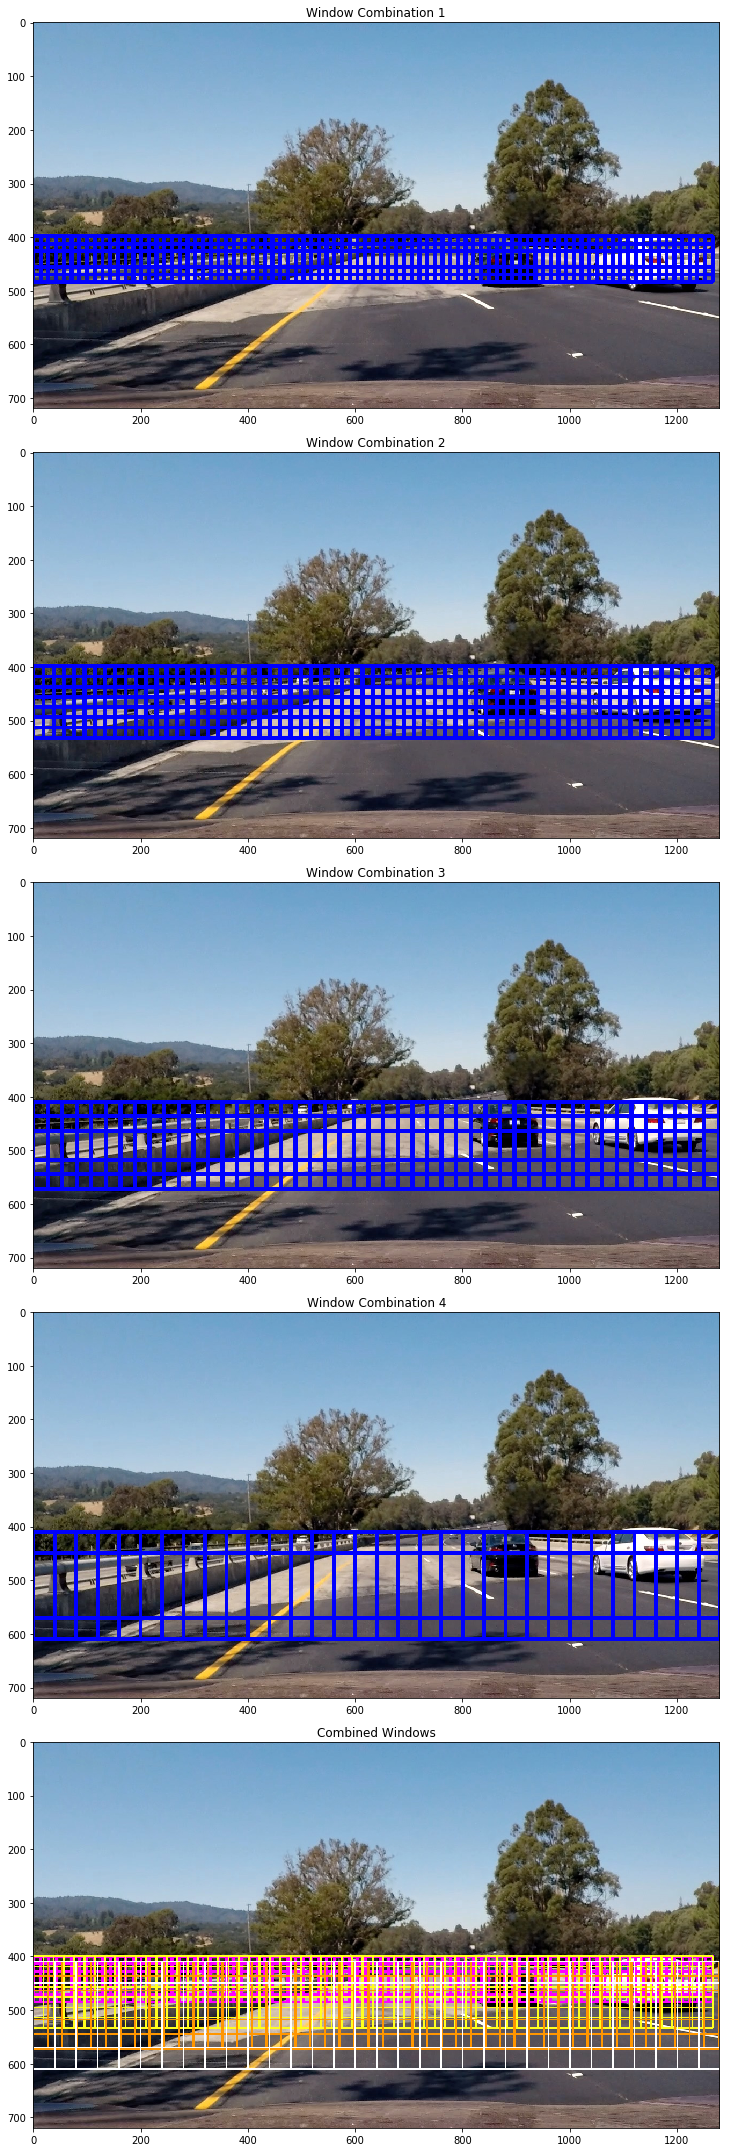

In [13]:
img = mpimg.imread(TEST_IMG_LOC)

draw_img = np.copy(img)

img1, windows1 = find_cars(
    img,
    [WIN_PARAMS[0]],
    SVC, 
    scaler=X_scaler,
    cspace=COLORSPACE,
    orient=ORIENT, 
    pix_per_cell=PIXEL_PER_CELL, 
    cell_per_block=CELL_PER_BLOCK,
    bin_spatial=FTR_BIN_SPTL,
    spatial_size=SPATIAL_SIZE,
    color_hist=FTR_CLR_HIST,
    hist_bins=HISTO_BINS,
    heatmap=False,
    heatmap_thresh=HEATMAP_THRES,
    return_boxes=True,
    return_all_boxes=True
)

img2, windows2 = find_cars(
    img,
    [WIN_PARAMS[1]],
    SVC, 
    scaler=X_scaler,
    cspace=COLORSPACE,
    orient=ORIENT, 
    pix_per_cell=PIXEL_PER_CELL, 
    cell_per_block=CELL_PER_BLOCK,
    bin_spatial=FTR_BIN_SPTL,
    spatial_size=SPATIAL_SIZE,
    color_hist=FTR_CLR_HIST,
    hist_bins=HISTO_BINS,
    heatmap=False,
    heatmap_thresh=HEATMAP_THRES,
    return_boxes=True,
    return_all_boxes=True
)

img3, windows3 = find_cars(
    img,
    [WIN_PARAMS[2]],
    SVC, 
    scaler=X_scaler,
    cspace=COLORSPACE,
    orient=ORIENT, 
    pix_per_cell=PIXEL_PER_CELL, 
    cell_per_block=CELL_PER_BLOCK,
    bin_spatial=FTR_BIN_SPTL,
    spatial_size=SPATIAL_SIZE,
    color_hist=FTR_CLR_HIST,
    hist_bins=HISTO_BINS,
    heatmap=False,
    heatmap_thresh=HEATMAP_THRES,
    return_boxes=True,
    return_all_boxes=True
)

img4, windows4 = find_cars(
    img,
    [WIN_PARAMS[3]],
    SVC, 
    scaler=X_scaler,
    cspace=COLORSPACE,
    orient=ORIENT, 
    pix_per_cell=PIXEL_PER_CELL, 
    cell_per_block=CELL_PER_BLOCK,
    bin_spatial=FTR_BIN_SPTL,
    spatial_size=SPATIAL_SIZE,
    color_hist=FTR_CLR_HIST,
    hist_bins=HISTO_BINS,
    heatmap=False,
    heatmap_thresh=HEATMAP_THRES,
    return_boxes=True,
    return_all_boxes=True
)

print("Total windows: ", len(windows1) + len(windows2) + len(windows3) + len(windows4))

window1_img = draw_boxes(draw_img, windows1, color=(255, 0, 255), thick=3)
window2_img = draw_boxes(window1_img, windows2, color=(255, 255, 30), thick=2)
window3_img = draw_boxes(window2_img, windows3, color=(255, 150, 0), thick=2)
all_windows = draw_boxes(window3_img, windows4, color=(255, 255, 255), thick=2)

fig, ax = plt.subplots(figsize=(15, 30))
plt.subplot(511)
plt.imshow(img1)
plt.title('Window Combination 1')
plt.subplot(512)
plt.imshow(img2)
plt.title('Window Combination 2')
plt.subplot(513)
plt.imshow(img3)
plt.title('Window Combination 3')
plt.subplot(514)
plt.imshow(img4)
plt.title('Window Combination 4')
plt.subplot(515)
plt.imshow(all_windows)
plt.title('Combined Windows')
fig.tight_layout()

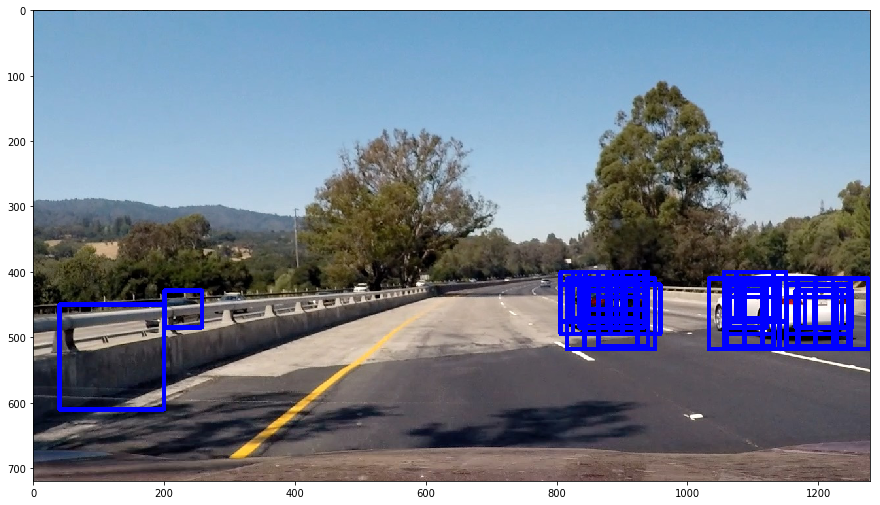

In [14]:
img = mpimg.imread(TEST_IMG_LOC)

img, all_windows =  find_cars(
    img, 
    WIN_PARAMS, 
    SVC, 
    scaler=X_scaler,
    cspace=COLORSPACE,
    orient=ORIENT, 
    pix_per_cell=PIXEL_PER_CELL, 
    cell_per_block=CELL_PER_BLOCK,
    bin_spatial=FTR_BIN_SPTL,
    spatial_size=SPATIAL_SIZE,
    color_hist=FTR_CLR_HIST,
    hist_bins=HISTO_BINS,
    heatmap=False,
    heatmap_thresh=HEATMAP_THRES,
    return_boxes=True
)
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(img)

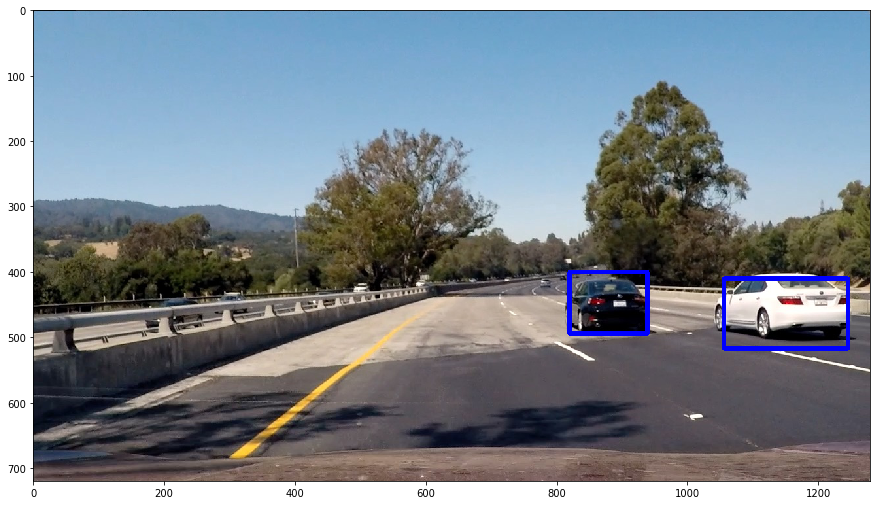

In [15]:
img = mpimg.imread(TEST_IMG_LOC)

hot_img, hot_windows =  find_cars(
    img, 
    WIN_PARAMS,
    SVC, 
    scaler=X_scaler,
    cspace=COLORSPACE,
    orient=ORIENT, 
    pix_per_cell=PIXEL_PER_CELL, 
    cell_per_block=CELL_PER_BLOCK,
    bin_spatial=FTR_BIN_SPTL,
    spatial_size=SPATIAL_SIZE,
    color_hist=FTR_CLR_HIST,
    hist_bins=HISTO_BINS,
    heatmap=HEATMAP,
    heatmap_thresh=HEATMAP_THRES,
    return_boxes=True,
    avg_heatmap=AverageHeatmap(1)
)
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(hot_img)

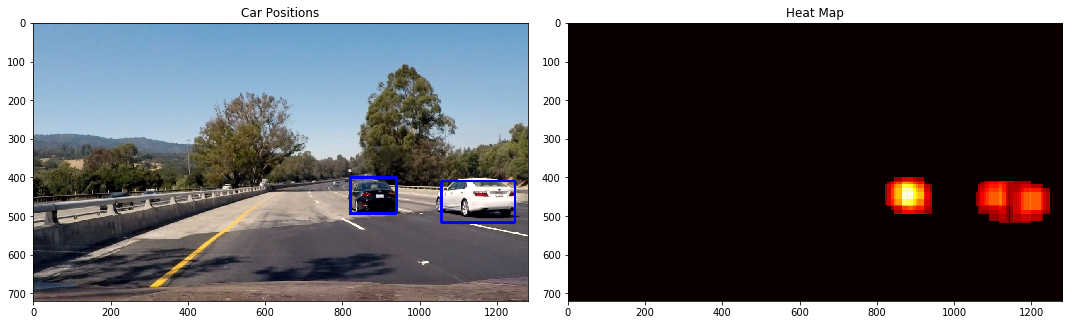

In [16]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, HEATMAP_THRES)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(draw_img, labels)

fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

1.6206634044647217 seconds
1.6211693286895752 seconds
1.711421012878418 seconds
1.6136822700500488 seconds
1.6396124362945557 seconds
1.5907442569732666 seconds


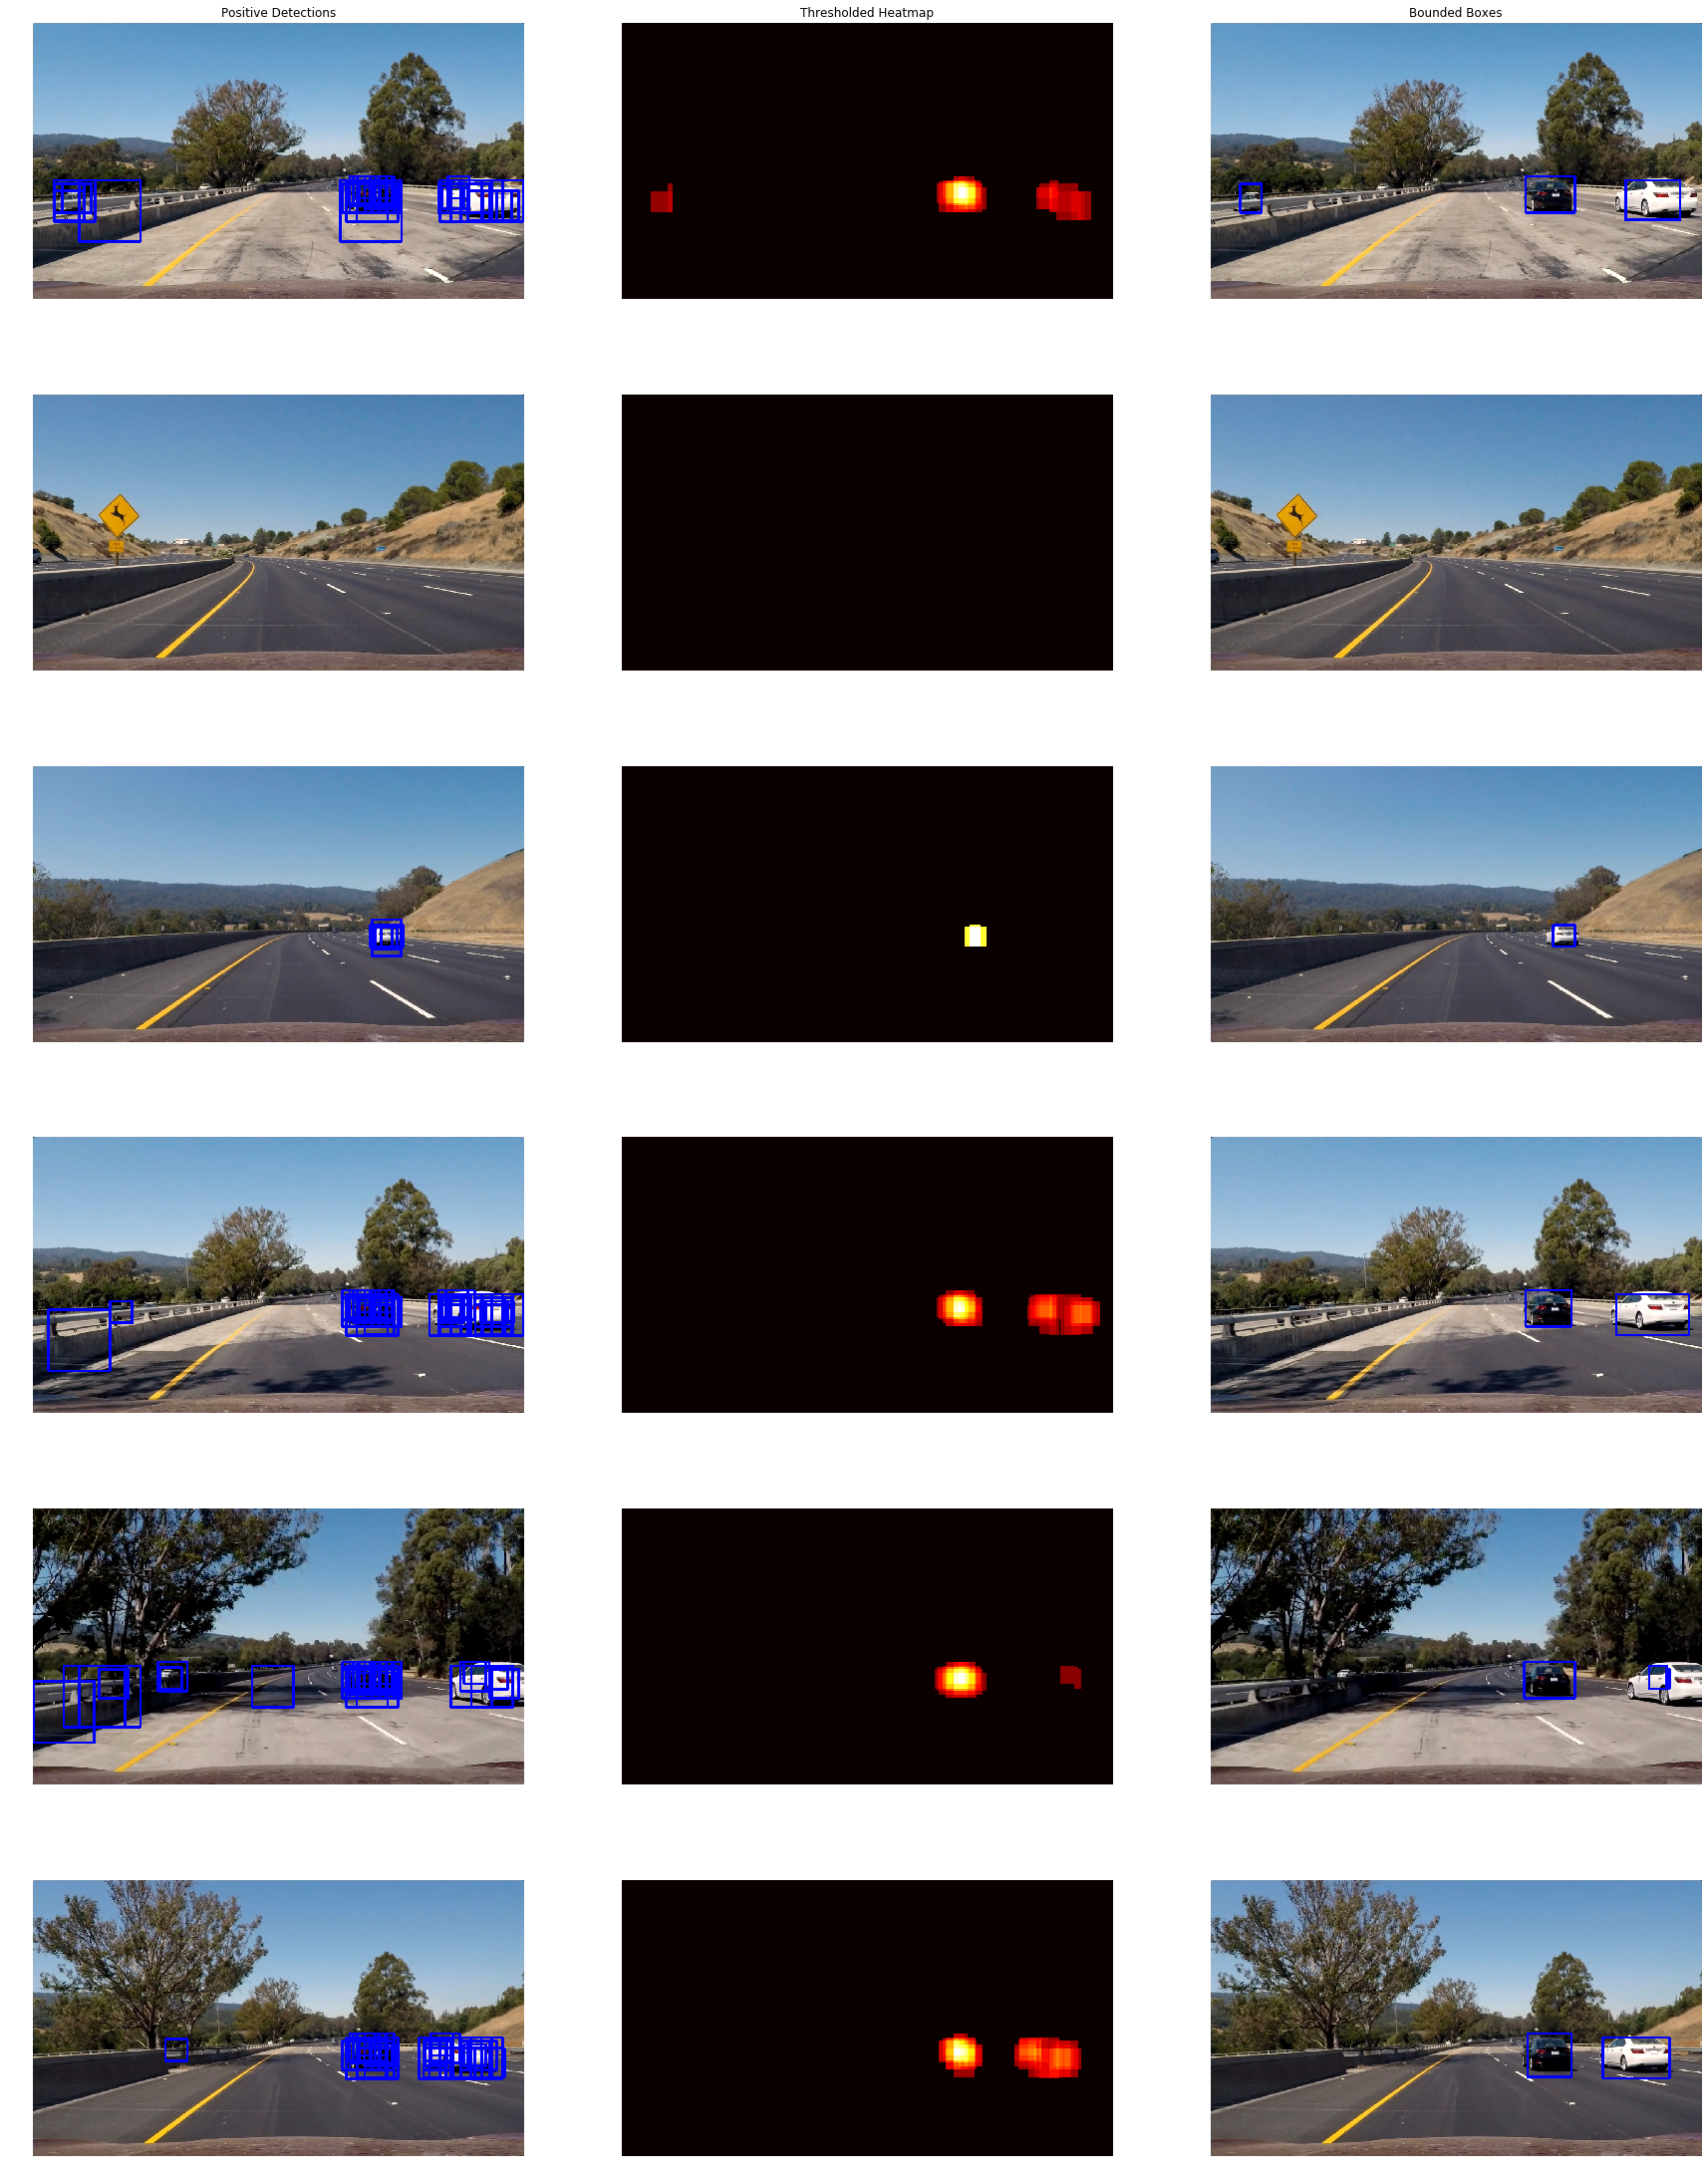

In [19]:
vehicle_img_locs = glob.glob('C:\\Users\\Yiqun\\Downloads\\CarND-Vehicle-Detection-master\\test_images\\*.jpg')

f, axarr = plt.subplots(6, 3)
f.set_size_inches(30, 40)

for i in range(6):
    t = time.time()
    if i == 0:
        axarr[i, 0].set_title("Positive Detections")
        axarr[i, 1].set_title("Thresholded Heatmap")
        axarr[i, 2].set_title("Bounded Boxes")
    # Plot images on figure
    img = mpimg.imread(vehicle_img_locs[i])
    draw_img = np.copy(img)

    all_windows =  find_cars(
        img, 
        WIN_PARAMS, 
        SVC, 
        scaler=X_scaler,
        cspace=COLORSPACE,
        orient=ORIENT, 
        pix_per_cell=PIXEL_PER_CELL, 
        cell_per_block=CELL_PER_BLOCK,
        bin_spatial=FTR_BIN_SPTL,
        spatial_size=SPATIAL_SIZE,
        color_hist=FTR_CLR_HIST,
        hist_bins=HISTO_BINS,
        heatmap=False,
        heatmap_thresh=HEATMAP_THRES,
        avg_heatmap=AverageHeatmap(1)
    )
    
    hot_img, hot_windows =  find_cars(
        img, 
        WIN_PARAMS, 
        SVC, 
        scaler=X_scaler,
        cspace=COLORSPACE,
        orient=ORIENT, 
        pix_per_cell=PIXEL_PER_CELL, 
        cell_per_block=CELL_PER_BLOCK,
        bin_spatial=FTR_BIN_SPTL,
        spatial_size=SPATIAL_SIZE,
        color_hist=FTR_CLR_HIST,
        hist_bins=HISTO_BINS,
        heatmap=HEATMAP,
        heatmap_thresh=HEATMAP_THRES,
        return_boxes=True,
        avg_heatmap=AverageHeatmap(1)
    )
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, HEATMAP_THRES)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    heatmap_img = draw_labeled_bboxes(draw_img, labels)
    t2 = time.time()
    print(t2-t, 'seconds')
    axarr[i, 0].imshow(all_windows)
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(heatmap, cmap='hot')
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(heatmap_img)
    axarr[i, 2].axis('off')

In [18]:
# Process each frame in the project video input and output a new video with cars identified
clip = VideoFileClip(VID_INPUT)
new_clip = clip.fl_image(find_cars_wrapper)
new_clip.write_videofile(VID_OUT, audio=False)

Moviepy - Building video C:\Users\Yiqun\Downloads\test_video_result.mp4.
Moviepy - Writing video C:\Users\Yiqun\Downloads\test_video_result.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Yiqun\Downloads\test_video_result.mp4
